In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Preprocessing

In [2]:
p18 = pd.read_csv('players_18.csv', encoding='latin-1') #players_18.csv file, some of the cases we encoded in latin1
p19 = pd.read_csv('players_19.csv', encoding='latin-1') #players_19.csv file, some of the cases we encoded in latin1
m_results = pd.read_csv('match_result.csv', encoding='latin-1') #match_results.csv file, some of the cases we encoded in latin1

In [3]:
#dropping unneeded variables from the player_18 and player_19 csv files first

#list of variables of interest (voi) that we want to keep for our models
voi_player = ['short_name', 'age', 'height_cm', 'weight_kg', 'club', 'wage_eur',
      'pace' ,'shooting', 'passing', 'dribbling', 'defending',
      'gk_handling', 'gk_speed', 'gk_kicking', 'gk_diving', 'gk_positioning']

columns_list_18 = p18.columns.values.tolist() #list of all columns
columns_list_19 = p19.columns.values.tolist()

for i in range(len(columns_list_18)): #iterate through list of columns
    if columns_list_18[i] not in voi_player: #if column is not in our variables of interest list
        p18.pop(columns_list_18[i]) #remove it from the df
        
for i in range(len(columns_list_19)):
    if columns_list_19[i] not in voi_player:
        p19.pop(columns_list_19[i])

In [4]:
p18['short_name'] = p18['short_name'].astype('category') #setting to correct variable types
p18['club'] = p18['club'].astype('category') #setting to correct variable types
p19['short_name'] = p19['short_name'].astype('category') #setting to correct variable types
p19['club'] = p19['club'].astype('category') #setting to correct variable types

In [5]:
p18.shape #confirming we cut out the 87 unneeded columns

(17592, 16)

In [6]:
p19.shape #confirming we cut out the 87 unneeded columns

(17770, 16)

In [7]:
#dropping unneeded variables from the match_results csv

#list of variables of interest (voi) that we want to keep for our models
voi_match = ['FTHG', 'FTAG', 'FTR', 'HomeTeam', 'AwayTeam']

columns_list_match = m_results.columns.values.tolist()

for i in range(len(columns_list_match)): #iterate through list of columns
    if columns_list_match[i] not in voi_match: #if column is not in our variables of interest list
        m_results.pop(columns_list_match[i]) #remove it from the df

In [8]:
m_results.head()

,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,Standard de Liège,KAA Gent,3,2,H
1,KV Kortrijk,RSC Anderlecht,1,4,A
2,KV Oostende,Royal Excel Mouscron,2,1,H
3,Sint-Truidense VV,KSV Cercle Brugge,0,0,D
4,SV Zulte-Waregem,Waasland-Beveren,2,2,D


In [9]:
m_results['HomeTeam'] = m_results['HomeTeam'].astype('category') #setting to correct variable types
m_results['AwayTeam'] = m_results['AwayTeam'].astype('category')
m_results['FTR'] = m_results['FTR'].astype('category')
m_results['FTR']= m_results['FTR'].replace(['H','A','D'],[1,2,0])
m_results.head()


,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,Standard de Liège,KAA Gent,3,2,1
1,KV Kortrijk,RSC Anderlecht,1,4,2
2,KV Oostende,Royal Excel Mouscron,2,1,1
3,Sint-Truidense VV,KSV Cercle Brugge,0,0,0
4,SV Zulte-Waregem,Waasland-Beveren,2,2,0


In [10]:
#group by team and calculate the mean
p18_team_mean = p18.groupby('club').mean().sort_values('pace',ascending=False)
p19_team_mean = p19.groupby('club').mean().sort_values('pace',ascending=False)

In [11]:
#preparing to merge table, by mean
HomeStatsMean = p18_team_mean
HomeStatsMean = HomeStatsMean.add_prefix('Home ')
HomeStatsMean = HomeStatsMean.reset_index()
AwayStatsMean = p18_team_mean
AwayStatsMean = AwayStatsMean.add_prefix('Away ')
AwayStatsMean = AwayStatsMean.reset_index()

In [12]:
temp = pd.merge(m_results,HomeStatsMean,'left',left_on='HomeTeam',right_on='club')
mean_table = pd.merge(temp, AwayStatsMean, 'left',left_on='AwayTeam',right_on='club')  #final table, all stats are mean

In [13]:
mean_table.columns

Index(['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'club_x', 'Home age',
       'Home height_cm', 'Home weight_kg', 'Home wage_eur', 'Home pace',
       'Home shooting', 'Home passing', 'Home dribbling', 'Home defending',
       'Home gk_diving', 'Home gk_handling', 'Home gk_kicking',
       'Home gk_speed', 'Home gk_positioning', 'club_y', 'Away age',
       'Away height_cm', 'Away weight_kg', 'Away wage_eur', 'Away pace',
       'Away shooting', 'Away passing', 'Away dribbling', 'Away defending',
       'Away gk_diving', 'Away gk_handling', 'Away gk_kicking',
       'Away gk_speed', 'Away gk_positioning'],
      dtype='object')

In [14]:
mean_table = mean_table.dropna()
mean_table.shape

(2638, 35)

# Preparing variables

In [15]:
X = mean_table.drop(['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'club_x','club_y'], axis=1)
y = mean_table['FTR']

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold

X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.fit_transform(X_test) 

# Gradient Boosting

In [21]:
#Gradient Boosting
lr_list = [0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]
kf = KFold(n_splits=10, shuffle=True, random_state=1)

for learning_rate in lr_list:
    gb = GradientBoostingClassifier(n_estimators=500, learning_rate=learning_rate, max_features=2,max_depth=2, random_state=5)

    print("Learning rate: ", learning_rate)
    print("Score:", cross_val_score(gb, X_train_sc, y_train, cv=kf, scoring='accuracy').mean())

Learning rate:  0.01
Score: 0.5170616113744075
Learning rate:  0.025
Score: 0.5033175355450237
Learning rate:  0.05
Score: 0.49763033175355453
Learning rate:  0.075
Score: 0.48246445497630336
Learning rate:  0.1
Score: 0.48483412322274877
Learning rate:  0.25
Score: 0.4592417061611374
Learning rate:  0.5
Score: 0.4672985781990521
Learning rate:  0.75
Score: 0.45734597156398105
Learning rate:  1
Score: 0.44928909952606644


In [22]:
gb_clf = GradientBoostingClassifier(n_estimators=500, learning_rate=0.01, max_features=2, max_depth=2, random_state=5)
gb_clf.fit(X_train_sc, y_train)
pred = gb_clf.predict(X_test_sc)

print("Confusion Matrix:")
print(confusion_matrix(y_test, pred))

print("Classification Report")
print(classification_report(y_test, pred))

Confusion Matrix:
[[  0  95  34]
 [  5 197  35]
 [  3  90  69]]
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       129
           1       0.52      0.83      0.64       237
           2       0.50      0.43      0.46       162

    accuracy                           0.50       528
   macro avg       0.34      0.42      0.37       528
weighted avg       0.38      0.50      0.43       528



# Random Forest

In [19]:
#Random forest
rf = RandomForestClassifier(n_estimators = 500, max_features = 6, random_state = 1)
rf.fit(X_train_sc, y_train)
pred2 = rf.predict(X_test_sc)

print("Confusion Matrix:")
print(confusion_matrix(y_test, pred2))

print("Classification Report")
print(classification_report(y_test, pred2))

print("Score:", cross_val_score(rf, X_train_sc, y_train, cv=10, scoring='accuracy').mean())

Confusion Matrix:
[[ 16  81  32]
 [ 36 161  40]
 [ 23  65  74]]
Classification Report
              precision    recall  f1-score   support

           0       0.21      0.12      0.16       129
           1       0.52      0.68      0.59       237
           2       0.51      0.46      0.48       162

    accuracy                           0.48       528
   macro avg       0.41      0.42      0.41       528
weighted avg       0.44      0.48      0.45       528

Score: 0.46966824644549765


<Figure size 1800x360 with 0 Axes>

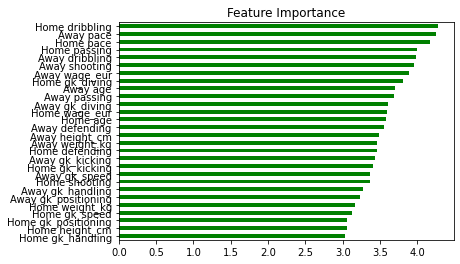

In [20]:
importance = pd.DataFrame({'importance': rf.feature_importances_*100}, 
                          index = X.columns)
importance.sort_values(by = 'importance', ascending = True, inplace = True)
plt.figure(figsize=(25,5))
importance.plot(kind = 'barh', color = 'g')
plt.title('Feature Importance')
plt.gca().legend_ = None